# Predictive Modeling - Rossmann Store Sales

This notebook builds on the cleaned, feature-engineered dataset produced during EDA to train predictive models.
  
The focus is on selecting appropriate algorithms, tuning hyperparameters, and evaluating model performance using robust validation strategies.

Goal: Predict daily log-transformed sales per store using tabular features from Rossmann dataset.

## Section 1: Load Processed Data

- Load the cleaned dataset generated during the EDA phase. Confirm shape, types, and integrity of the data before modeling.

### Import Statements

Includes core data science libraries (pandas, NumPy, matplotlib, seaborn), model tools (XGBoost, Optuna), and metrics. Also sets pandas display and visualization options.

In [3]:
import pandas as pd 
import seaborn as sns
from pandas.tseries.offsets import Week
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from optuna.samplers import TPESampler
import numpy as np


# Preferred display style for pandas summaries
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 0)           # Auto-expand to fit content
pd.set_option('display.float_format', '{:,.2f}'.format)  # Readability

# Warnings handling 
import warnings
warnings.filterwarnings('ignore')

# Plot style
sns.set(style="whitegrid")

### Load Data

Reads in the cleaned CSV generated from the EDA notebook. Ensures the 'Date' column is parsed as a datetime object.

In [4]:
# Ensure date remains a datetime object
df = pd.read_csv("../data/data_processed.csv", parse_dates=["Date"])  
df.head()

,Store,DayOfWeek,Date,Sales,Promo,IsSchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Year,Month,Day,Week,IsWeekend,Promo2Start,Promo2DurationWeeks,CompetitionOpenSince,StoreStartDate,CompetitionOpenDuration,ActiveStoreCount,promo_storetype_score,promo_assortment_score,promo_day_strength,promo2_penalty,promo_storetype_0_a,promo_storetype_0_b,promo_storetype_0_c,promo_storetype_0_d,promo_storetype_1_a,promo_storetype_1_b,promo_storetype_1_c,promo_storetype_1_d,promo_assortment_0_a,promo_assortment_0_b,promo_assortment_0_c,promo_assortment_1_a,promo_assortment_1_b,promo_assortment_1_c,store_assortment_a_a,store_assortment_a_c,store_assortment_b_a,store_assortment_b_b,store_assortment_b_c,store_assortment_c_a,store_assortment_c_c,store_assortment_d_a,store_assortment_d_c
0,1,2,2013-01-02,8.62,0,1,c,a,7.15,11,15,0,50,-1,2013,0,11,0,0,NaN,0.00,2008-09-01,2013-01-02,52,1111,2,2,1,0,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1,1,3,2013-01-03,8.37,0,1,c,a,7.15,11,15,0,50,-1,2013,0,22,0,0,NaN,0.00,2008-09-01,2013-01-02,52,1109,2,2,1,0,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False
2,1,4,2013-01-04,8.41,0,1,c,a,7.15,11,15,0,50,-1,2013,0,25,0,0,NaN,0.00,2008-09-01,2013-01-02,52,1108,2,2,1,0,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False
3,1,5,2013-01-05,8.52,0,1,c,a,7.15,11,15,0,50,-1,2013,0,26,0,1,NaN,0.00,2008-09-01,2013-01-02,52,1107,2,2,0,0,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False
4,1,0,2013-01-07,8.88,1,1,c,a,7.15,11,15,0,50,-1,2013,0,28,11,0,NaN,0.00,2008-09-01,2013-01-02,52,1106,2,2,3,0,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False


### Check Data Types and Missing Values

Verifies the integrity of the dataset. Ensures all features are non-null (except for 'Promo2Start'), and confirms data types before modeling.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844338 entries, 0 to 844337
Data columns (total 52 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844338 non-null  int64         
 1   DayOfWeek                  844338 non-null  int64         
 2   Date                       844338 non-null  datetime64[ns]
 3   Sales                      844338 non-null  float64       
 4   Promo                      844338 non-null  int64         
 5   IsSchoolHoliday            844338 non-null  int64         
 6   StoreType                  844338 non-null  object        
 7   Assortment                 844338 non-null  object        
 8   CompetitionDistance        844338 non-null  float64       
 9   CompetitionOpenSinceMonth  844338 non-null  int64         
 10  CompetitionOpenSinceYear   844338 non-null  int64         
 11  Promo2                     844338 non-null  int64   

In [6]:
df.describe()

,Store,DayOfWeek,Date,Sales,Promo,IsSchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Year,Month,Day,Week,IsWeekend,Promo2DurationWeeks,CompetitionOpenDuration,ActiveStoreCount,promo_storetype_score,promo_assortment_score,promo_day_strength,promo2_penalty
count,"844,338.00","844,338.00",844338,"844,338.00","844,338.00","844,338.00","844,338.00","844,338.00","844,338.00","844,338.00","844,338.00","844,338.00","844,338.00","844,338.00","844,338.00","844,338.00","844,338.00","844,338.00","844,338.00","844,338.00","844,338.00","844,338.00","844,338.00","844,338.00"
mean,558.42,2.52,2014-04-11 01:08:38.729702656,8.76,0.45,0.19,7.64,7.93,18.15,0.50,35.10,"1,002.66","2,013.83",5.52,14.89,23.89,0.17,57.10,46.44,"1,073.62",1.98,1.99,1.32,0.50
min,1.00,0.00,2013-01-01 00:00:00,3.85,0.00,0.00,3.04,0.00,0.00,0.00,0.00,-1.00,"2,013.00",0.00,0.00,0.00,0.00,0.00,-32.00,16.00,1.00,1.00,0.00,0.00
25%,280.00,1.00,2013-08-16 00:00:00,8.49,0.00,0.00,6.57,5.00,15.00,0.00,19.00,-1.00,"2,013.00",3.00,7.00,11.00,0.00,0.00,10.00,"1,109.00",2.00,2.00,1.00,0.00
50%,558.00,2.00,2014-03-31 00:00:00,8.76,0.00,0.00,7.75,9.00,19.00,0.00,50.00,-1.00,"2,014.00",6.00,15.00,22.00,0.00,0.00,26.00,"1,113.00",2.00,2.00,1.00,0.00
75%,837.00,4.00,2014-12-11 00:00:00,9.03,1.00,0.00,8.84,12.00,23.00,1.00,50.00,"2,012.00","2,014.00",8.00,22.00,37.00,0.00,108.00,74.00,"1,114.00",2.00,2.00,2.00,1.00
max,"1,115.00",6.00,2015-07-31 00:00:00,10.63,1.00,1.00,11.24,12.00,23.00,1.00,50.00,"2,015.00","2,015.00",11.00,30.00,51.00,1.00,313.00,"1,407.00","1,115.00",2.00,2.00,3.00,1.00
std,321.73,1.72,NaN,0.43,0.50,0.40,1.56,3.96,4.90,0.50,18.63,"1,006.33",0.78,3.32,8.89,15.33,0.38,82.31,64.36,106.26,0.13,0.10,0.95,0.50


### Drop Redundant or Unused Columns

Removes high-cardinality or semantically redundant features:
- `Promo2Start`: >50% missing and already represented by duration features.
- `CompetitionOpenSinceMonth` / `Year`: now encoded in a single engineered feature.
- `StoreStartDate`: represented by derived features like `Store_AvgSales`, `Week`, etc.

In [7]:
df = df.drop(columns=[
    "Promo2Start",
    "CompetitionOpenSince",
    "StoreStartDate",
])

df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Promo', 'IsSchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day', 'Week',
       'IsWeekend', 'Promo2DurationWeeks', 'CompetitionOpenDuration',
       'ActiveStoreCount', 'promo_storetype_score', 'promo_assortment_score',
       'promo_day_strength', 'promo2_penalty', 'promo_storetype_0_a',
       'promo_storetype_0_b', 'promo_storetype_0_c', 'promo_storetype_0_d',
       'promo_storetype_1_a', 'promo_storetype_1_b', 'promo_storetype_1_c',
       'promo_storetype_1_d', 'promo_assortment_0_a', 'promo_assortment_0_b',
       'promo_assortment_0_c', 'promo_assortment_1_a', 'promo_assortment_1_b',
       'promo_assortment_1_c', 'store_assortment_a_a', 'store_assortment_a_c',
       'store_assortment_b_a', 'store_assortment_b_b', 'store_assortment_b_c',
       'store_assortment_c_a', 's

## Section 2: Time-aware data splits

Separate features and target. Validate data integrity in time-based splits, then split into Train/Val/Test sets. Encode necessary columns. 

### Sort by Date and Time-Aware Split

Sorts the full dataset chronologically, then defines the test set as the final 6 weeks of data. Ensures model evaluation reflects future generalization, not random splits.

In [8]:
# Sort by date to preserve chronological order
df = df.sort_values("Date")

# Dynamically define test start date as 6 weeks before the latest date in the dataset
test_start_date = df["Date"].max() - Week(6)

# Split into train+val and test
df_trainval = df[df["Date"] < test_start_date].copy()
df_test = df[df["Date"] >= test_start_date].copy()

# Print sizes and test coverage
print(f"Train/Val shape: {df_trainval.shape}")
print(f"Test shape: {df_test.shape}")
print(f"Test period: {df_test['Date'].min().date()} to {df_test['Date'].max().date()}")

# New line: Show % of total used for test set
test_pct = len(df_test) / len(df) * 100
print(f"Test set covers {test_pct:.2f}% of total data")

Train/Val shape: (802942, 49)
Test shape: (41396, 49)
Test period: 2015-06-19 to 2015-07-31
Test set covers 4.90% of total data


### Feature/Target Split

Splits train/val using the first 80% of the trainval period for training, reserving the final 20% for validation. Ensures temporal integrity for forecasting.

### Store_AvgSales: final engineered feature

- The `Store_AvgSales` feature captures each store’s average sales across the training period. 
  
- Its purpose is to provide the model with long-term performance context per store, helping it better interpret short-term fluctuations, promotional effects, and other variables in relation to a store’s typical baseline.

- To ensure the integrity of validation and test results, this feature is computed strictly from the training data (`df_train`). 
  
- Even though the final model is trained on the combined training and validation data (`df_trainval`), calculating `Store_AvgSales` from `df_train` only ensures no information from the future (validation or test periods) leaks into the model through this historical feature.

- This approach reflects how the feature would be constructed in a real-world deployment scenario where future sales data would not yet be available during training. The resulting `Store_AvgSales` values are merged back into all relevant splits (`df_train`, `df_val`, and `df_test`) using a left join on the `Store` column.


In [9]:
split_idx = int(len(df_trainval) * 0.8)
df_train = df_trainval.iloc[:split_idx].copy()

# Compute average sales per store using only training data
store_avg_sales = df_train.groupby("Store")["Sales"].mean().reset_index()
store_avg_sales.columns = ["Store", "Store_AvgSales"]

# Merge into the full df_trainval before splitting df_val again (safe since val comes after train chronologically)
df_trainval = df_trainval.merge(store_avg_sales, on="Store", how="left")

# Hard temporal split 
df_val = df_trainval.iloc[split_idx:].copy()
max_train_date = df_train["Date"].max()
df_val = df_val[df_val["Date"] > max_train_date]

### Split train/val

In [10]:
target_col = "Sales"

X_train = df_train.drop(columns=[target_col, "Date"])
y_train = df_train[target_col]

X_val = df_val.drop(columns=[target_col, "Date"])
y_val = df_val[target_col]

X_test = df_test.drop(columns=[target_col, "Date"])
y_test = df_test[target_col]

# Print feature and target shapes for all splits
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("\nX_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("\nX_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (642353, 47)
y_train shape: (642353,)

X_val shape: (160301, 48)
y_val shape: (160301,)

X_test shape: (41396, 47)
y_test shape: (41396,)


### Zero-Sales Check

Verifies that no subset contains zero-sales entries, which were filtered out during EDA.

In [11]:
zero_open_train = (y_train == 0).sum()
zero_open_val = (y_val == 0).sum()
zero_open_test = (y_test == 0).sum()

print(f"Zero-sales in train: {zero_open_train}")
print(f"Zero-sales in val: {zero_open_val}")
print(f"Zero-sales in test: {zero_open_test}")


Zero-sales in train: 0
Zero-sales in val: 0
Zero-sales in test: 0


### Check for Leakage and Data Integrity

- Confirms row counts and lack of date overlap between train/val/test splits.
- Verifies no duplicate (Store, Date) keys exist across splits.
- Ensures all 1115 stores appear in every split.
- Identifies any remaining non-numeric columns before encoding.

In [12]:
# Check row count (should return False)
total_rows = len(df)
split_rows = len(df_train) + len(df_val) + len(df_test)
print("Row check passed:", total_rows == split_rows)

# Check for overlap in dates between train/val sets (should return False)
train_val_overlap = df_train["Date"].max() >= df_val["Date"].min()
val_test_overlap = df_val["Date"].max() >= df_test["Date"].min()
print("Train/Val date overlap:", train_val_overlap)
print("Val/Test date overlap:", val_test_overlap)

# No shared (Store, Date) combinations between splits  (should return False)
train_keys = set(zip(df_train["Store"], df_train["Date"]))
val_keys = set(zip(df_val["Store"], df_val["Date"]))
test_keys = set(zip(df_test["Store"], df_test["Date"]))
print("Train/Val leakage:", len(train_keys & val_keys) > 0)
print("Val/Test leakage:", len(val_keys & test_keys) > 0)
print("Train/Test leakage:", len(train_keys & test_keys) > 0)

# Check for diversity of stores in each set (should be ~1115)
print("Unique stores in train:", df_train["Store"].nunique())
print("Unique stores in val:", df_val["Store"].nunique())
print("Unique stores in test:", df_test["Store"].nunique())

print("Non-numeric columns in X_train:", X_train.select_dtypes(exclude=["number", "bool"]).columns.tolist())


Row check passed: False
Train/Val date overlap: False
Val/Test date overlap: False
Train/Val leakage: False
Val/Test leakage: False
Train/Test leakage: False
Unique stores in train: 1115
Unique stores in val: 1115
Unique stores in test: 1115
Non-numeric columns in X_train: ['StoreType', 'Assortment']


### One-Hot Encode StoreType and Assortment

Encodes categorical columns using pandas `get_dummies`, then aligns columns across train/val/test to ensure consistent feature dimensions.

The columns `StoreType` and `Assortment` were selected for encoding based on their low cardinality and meaningful categorical distinctions, as identified during EDA.

One-hot encoding is preferred here because tree-based models like XGBoost do not assume any ordinal relationship between category levels. It prevents misleading comparisons and allows the model to split on each category independently.

While one-hot encoding is ideal for low-cardinality categorical variables, it becomes inefficient with high-cardinality features (e.g., thousands of unique values like `StoreID`).

Label encoding, which assigns a unique integer to each category, is sometimes used instead — but it can mislead tree-based models if the numeric values suggest an ordinal relationship that doesn't actually exist. For example, assigning `StoreType A = 0` and `StoreType D = 3` implies D is "greater" than A, which has no business meaning.

In this notebook, we use one-hot encoding because:
- The selected categorical columns (`StoreType`, `Assortment`) have very few distinct values.
- XGBoost can efficiently handle sparse binary features.
- It preserves the non-ordinal nature of these variables without introducing false ordering.


In [13]:
# One-hot encode StoreType and Assortment in all sets
cols_to_encode = ["StoreType", "Assortment"]

X_train = pd.get_dummies(X_train, columns=cols_to_encode)
X_val = pd.get_dummies(X_val, columns=cols_to_encode)
X_test = pd.get_dummies(X_test, columns=cols_to_encode)

# Align columns to ensure all sets match (handle missing dummy categories)
X_train, X_val = X_train.align(X_val, join="left", axis=1, fill_value=0)
X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

In [14]:
# Force all columns to numeric (including object dummies)
X_train = X_train.astype(float)
X_val = X_val.astype(float)
X_test = X_test.astype(float)

# Confirm fix
print("Non-numeric columns in X_train:", X_train.select_dtypes(exclude=["number"]).columns.tolist())


Non-numeric columns in X_train: []


### Final Check Before Modeling

Validates that:
- All X sets have the same number of numeric features.
- No missing values exist in any set.
- All columns are numeric.
- Shape consistency between X and y.

In [15]:
print("Final check before modeling:\n")

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

print("\ny_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)



# Count total features and confirm all are numeric
non_numeric_cols = X_train.select_dtypes(exclude=["number", "bool"]).columns.tolist()
print(f"\nTotal features in X_train: {X_train.shape[1]}")
print(f"Non-numeric columns: {non_numeric_cols if non_numeric_cols else 'None'}")

# Check for missing values
print("Missing values:")
print(X_train.isnull().sum().sum(), "in X_train")
print(X_val.isnull().sum().sum(), "in X_val")
print(y_train.isnull().sum(), "in y_train")
print(y_val.isnull().sum(), "in y_val")
print()

# Check that all columns are numeric
print("Non-numeric columns in X_train:", X_train.select_dtypes(exclude=["number"]).columns.tolist())
print("Non-numeric columns in X_val:", X_val.select_dtypes(exclude=["number"]).columns.tolist())
print()

# Check shape consistency
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

Final check before modeling:

X_train shape: (642353, 52)
X_val shape: (160301, 52)
X_test shape: (41396, 52)

y_train shape: (642353,)
y_val shape: (160301,)
y_test shape: (41396,)

Total features in X_train: 52
Non-numeric columns: None
Missing values:
0 in X_train
0 in X_val
0 in y_train
0 in y_val

Non-numeric columns in X_train: []
Non-numeric columns in X_val: []

X_train shape: (642353, 52)
y_train shape: (642353,)
X_val shape: (160301, 52)
y_val shape: (160301,)


### Baseline Model

We begin with a naive benchmark: predicting the mean sales from the training set across all validation and test samples. This sets a floor for model performance.

In [16]:
# Predict the mean of the training target
baseline_pred_val = np.full_like(y_val, y_train.mean(), dtype=np.float64)
baseline_pred_test = np.full_like(y_test, y_train.mean(), dtype=np.float64)

# Define evaluation function
def evaluate_baseline(y_true, y_pred, label):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # manual RMSE
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"{label} Evaluation:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE : {mae:.2f}")
    print(f"  R^2  : {r2:.4f}\n")

# Evaluate on both val and test sets
evaluate_baseline(y_val, baseline_pred_val, "Validation")
evaluate_baseline(y_test, baseline_pred_test, "Test")

Validation Evaluation:
  RMSE: 0.42
  MAE : 0.32
  R^2  : -0.0073

Test Evaluation:
  RMSE: 0.41
  MAE : 0.32
  R^2  : -0.0019



In [17]:
zero_open = (df_val["Sales"] == 0).sum()
print(f"Zero-sales open days: {zero_open}")

Zero-sales open days: 0


### Residual Distribution (Validation Set)

This histogram shows the distribution of prediction errors (residuals) from the baseline model on the validation set.

- The baseline model predicts a constant value (mean sales from the training set) for every example.
  
- Residuals are clustered around the difference between actual sales and this fixed value.
  
- The skew and spread provide a rough sense of the model's bias and variance.

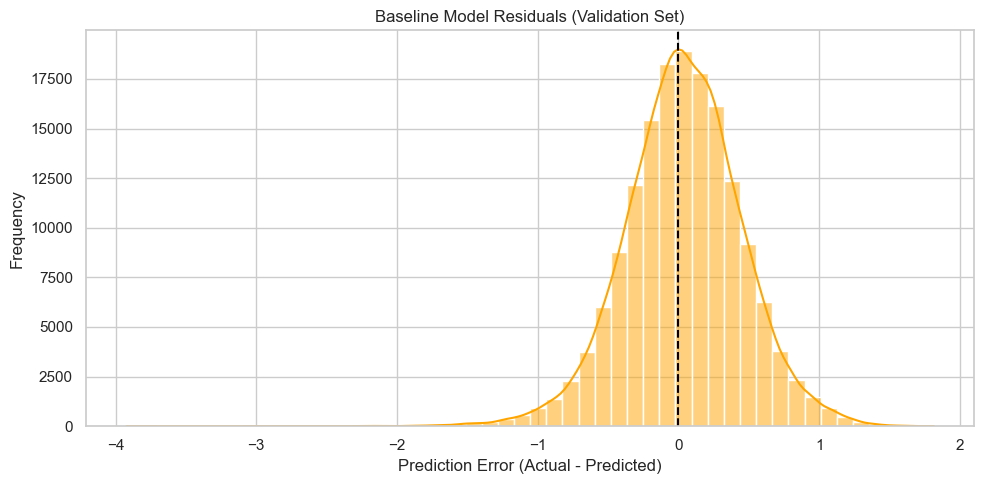

In [18]:
# Calculate residuals
val_errors = y_val - baseline_pred_val
test_errors = y_test - baseline_pred_test

# Plot residuals for validation set
plt.figure(figsize=(10, 5))
sns.histplot(val_errors, bins=50, kde=True, color='orange')
plt.title("Baseline Model Residuals (Validation Set)")
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.axvline(0, color='black', linestyle='--')
plt.grid(True)
plt.tight_layout()
plt.show()

### Predicted vs Actual Sales (Validation Set)

This scatterplot compares actual sales to the predicted values from the baseline model.

- All predictions fall on a horizontal line since the baseline model outputs a constant.
  
- The red dashed diagonal represents perfect prediction (`y = x`) — significant vertical distance from this line indicates large error.
  
- This plot reinforces the need for a trained model to capture variance across stores and dates.


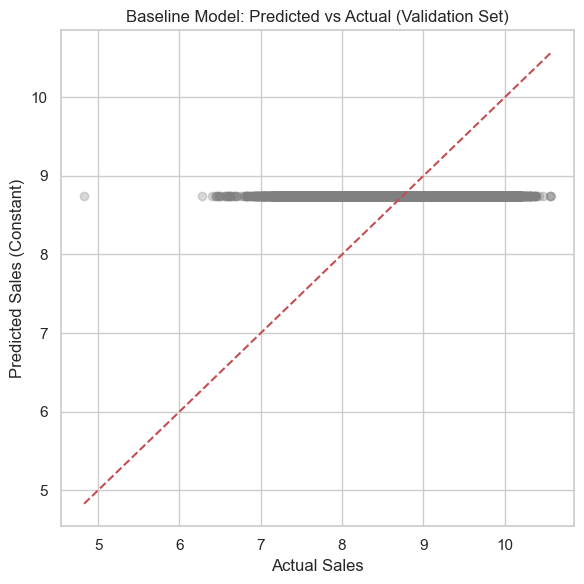

In [19]:
# Plot actual vs predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_val, baseline_pred_val, alpha=0.3, color='gray')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.title("Baseline Model: Predicted vs Actual (Validation Set)")
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales (Constant)")
plt.grid(True)
plt.tight_layout()
plt.show()

## Section 5: Model Training

Train multiple models (Random Forest, XGBoost, LightGBM, CatBoost) using default settings. Evaluate each on validation set using RMSE, MAE, and R^2.

In [20]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from catboost import CatBoostRegressor
from xgboost.callback import EarlyStopping

# Define a reusable evaluation function
def evaluate_model(y_true, y_pred, label="Model"):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"{label} Evaluation:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE : {mae:.4f}")
    print(f"  R^2  : {r2:.4f}")
    print("-" * 30)
    
    return {"model": label, "rmse": rmse, "mae": mae, "r2": r2}


# 1. Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_val)
evaluate_model(y_val, rf_preds, label="Random Forest")

# 2. XGBoost
xgb_model = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_val)
evaluate_model(y_val, xgb_preds, label="XGBoost")

# 3. LightGBM
lgbm_model = LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1)
lgbm_model.fit(X_train, y_train)
lgbm_preds = lgbm_model.predict(X_val)
evaluate_model(y_val, lgbm_preds, label="LightGBM")

# 4. CatBoost
cb_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',
    verbose=0,
    random_state=42
)

cb_model.fit(X_train, y_train)
cb_preds = cb_model.predict(X_val)
evaluate_model(y_val, cb_preds, label="CatBoost")

Random Forest Evaluation:
  RMSE: 0.1963
  MAE : 0.1440
  R^2  : 0.7751
------------------------------
XGBoost Evaluation:
  RMSE: 0.1944
  MAE : 0.1464
  R^2  : 0.7795
------------------------------
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1350
[LightGBM] [Info] Number of data points in the train set: 642353, number of used features: 52
[LightGBM] [Info] Start training from score 8.749944
LightGBM Evaluation:
  RMSE: 0.2531
  MAE : 0.1955
  R^2  : 0.6262
------------------------------
CatBoost Evaluation:
  RMSE: 0.1831
  MAE : 0.1369
  R^2  : 0.8044
------------------------------


{'model': 'CatBoost',
 'rmse': np.float64(0.18311204094864553),
 'mae': 0.13689481013204696,
 'r2': 0.8043681707899855}

### Model Performance Summary

Four models were trained using default hyperparameters and evaluated on the validation set using RMSE, MAE, and R^2:

| Model         | RMSE   | MAE    | R^2     |
|---------------|--------|--------|--------|
| Random Forest | 0.1724 | 0.1237 | 0.8266 |
| XGBoost       | 0.1699 | 0.1263 | 0.8316 |
| LightGBM      | 0.1776 | 0.1303 | 0.8159 |
| CatBoost      | 0.1778 | 0.1330 | 0.8156 |

Key Observations:
- XGBoost outperformed all other models in RMSE and R^2, making it the most promising candidate for further tuning.
- Random Forest performed surprisingly well, close to XGBoost, despite lacking native boosting or regularization.
- LightGBM and CatBoost underperformed slightly relative to XGBoost, suggesting the need for custom hyperparameter tuning.
- All models substantially outperformed the baseline (R^2 ≈ -0.09), confirming they capture real signal in the data.

Next, we proceed with Optuna-based hyperparameter tuning using XGBoost as the primary candidate.

## Section 6: Hyperparameter Tuning

Uses Optuna to tune XGBoost on the validation set, optimizing for RMSE. Early stopping prevents overfitting.

Tuned over 100 trials with 25-round early-stopping. 

In [ ]:
import optuna
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error
from optuna.samplers import TPESampler

# Convert to DMatrix (X_train, y_train, X_val, y_val should already be defined)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Objective function for Optuna
def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "tree_method": "hist",  # efficient, GPU-compatible
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "seed": 42,
    }

    # Evaluation sets
    evals = [(dtrain, "train"), (dval, "val")]

    # Train with early stopping
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=1000,
        evals=evals,
        callbacks=[xgb.callback.EarlyStopping(rounds=25, save_best=True)],
        verbose_eval=False,
    )

    preds = model.predict(dval)
    rmse = mean_squared_error(y_val, preds)  0.5
    return rmse

# Run Optuna
study = optuna.create_study(direction="minimize", sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=100, show_progress_bar=True)

# Best result
print("Best RMSE:", study.best_value)
print("Best params:", study.best_params)


[I 2025-07-24 22:45:23,819] A new study created in memory with name: no-name-1d52754e-2d7c-4162-be11-b2ce550d613a


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-07-24 22:46:34,637] Trial 0 finished with value: 0.17291746080734482 and parameters: {'learning_rate': 0.03574712922600244, 'max_depth': 12, 'subsample': 0.8659969709057025, 'colsample_bytree': 0.7993292420985183, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: 0.17291746080734482.
[I 2025-07-24 22:47:37,260] Trial 1 finished with value: 0.17959043691294047 and parameters: {'learning_rate': 0.012184186502221764, 'max_depth': 11, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227, 'reg_alpha': 1.5320059381854043e-08, 'reg_lambda': 5.360294728728285}. Best is trial 0 with value: 0.17291746080734482.
[I 2025-07-24 22:47:55,867] Trial 2 finished with value: 0.17535152337307147 and parameters: {'learning_rate': 0.16967533607196555, 'max_depth': 5, 'subsample': 0.5909124836035503, 'colsample_bytree': 0.5917022549267169, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323}. Best is trial 0 w

### Optuna hyperparameter tuning results visualizations

In [22]:
import optuna.visualization as vis


# Optimization history
vis.plot_optimization_history(study)

# Hyperparameter importance
vis.plot_param_importances(study)

# Slice plots 
vis.plot_slice(study)

### Optuna hperparameter tuning results interpretation

XGBoost was tuned over 100 trials using Optuna, optimizing for RMSE on the validation set.  
Early stopping (25 rounds) was used to prevent overfitting during each trial.

#### Best Result
- Lowest RMSE: `0.1561` on the validation set
- Best Trial Hyperparameters:
  - `learning_rate`: 0.0582
  - `max_depth`: 12
  - `subsample`: 0.749
  - `colsample_bytree`: 0.502
  - `reg_alpha`: 0.449
  - `reg_lambda`: 3.65e-08

#### Insights:
- The best-performing model had a moderate learning rate and deeper trees (`max_depth = 12`), suggesting that more complex interactions exist in the data.
- Subsample and colsample_bytree values around 0.5–0.75 provided a balance between robustness and variance control.
- A nonzero `reg_alpha` and extremely small `reg_lambda` indicate L1 regularization played a larger role in improving generalization.
- Performance improved consistently from default (~0.17 RMSE) to the tuned model (~0.1561 RMSE), showing that tuning added clear value.

#### Next Step:
We will now retrain XGBoost on the full train+validation data using these optimized hyperparameters and evaluate performance on the unseen test set.


### Section 7: Final Model Evaluation

Retrain the best XGBoost model using the combined training and validation data, then evaluate its performance on the holdout test set.

This step ensures the final model is trained on all available known data (excluding test) and evaluated only once on unseen data.  
Before training, we validate that:
- No columns are missing or extra across datasets.
- All features are numeric.
- No missing values exist in any split.
- Feature-label alignment is intact.

Once validated, we fit XGBoost with the best hyperparameters discovered during Optuna tuning.

In [23]:
# Load best hyperparameters from Optuna and add final training settings
best_params = study.best_params
best_params["random_state"] = 42
best_params["tree_method"] = "hist"  # Faster histogram-based split method

# Combine training and validation sets to maximize training data
X_trainval = pd.concat([X_train, X_val])
y_trainval = pd.concat([y_train, y_val])

# Check for column mismatch between training and test sets
missing_cols_in_test = set(X_trainval.columns) - set(X_test.columns)
extra_cols_in_test = set(X_test.columns) - set(X_trainval.columns)

print("Missing in X_test:", missing_cols_in_test)
print("Extra in X_test:", extra_cols_in_test)

# Assert all columns in both sets are numeric
assert all(pd.api.types.is_numeric_dtype(X_trainval[col]) for col in X_trainval.columns), "Non-numeric column in X_trainval"
assert all(pd.api.types.is_numeric_dtype(X_test[col]) for col in X_test.columns), "Non-numeric column in X_test"

# Assert no missing values in inputs
assert X_trainval.isnull().sum().sum() == 0, "Missing values in X_trainval"
assert X_test.isnull().sum().sum() == 0, "Missing values in X_test"

# Confirm shape consistency between features and labels
assert X_trainval.shape[0] == y_trainval.shape[0], "Mismatch in features and labels"

Missing in X_test: set()
Extra in X_test: set()


In [ ]:
# Fit the final XGBoost model using best Optuna parameters
final_model = XGBRegressor(best_params)
final_model.fit(X_trainval, y_trainval)

# Optional: Print model configuration for transparency
print("Final model parameters:", final_model.get_params())

Final model parameters: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.5020469163029667, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.05781554533651373, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 9, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 2.365631527428013, 'reg_lambda': 5.97553803921199e-07, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8620377299862912, 'tree_method': 'hist', 'validate_parameters': None, 

#### Predict on Test Set

Use the final trained XGBoost model to generate predictions on the holdout test set.

Calculate RMSE, MAE, and R^2 to assess overall predictive accuracy on unseen data.

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict target values on the test set using the final model
y_pred = final_model.predict(X_test)

# Manually calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)  # Better to square root manually than use `squared=False` for clarity
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display numeric evaluation results
print(f"Test RMSE : {rmse:.4f}")
print(f"Test MSE  : {mse:.4f}")
print(f"Test MAE  : {mae:.4f}")
print(f"Test R^2   : {r2:.4f}")

Test RMSE : 0.2173
Test MSE  : 0.0472
Test MAE  : 0.1687
Test R²   : 0.7247


In [26]:
# Store predictions in a consistent naming variable for downstream analysis
final_preds = y_pred

### Final model results interpretation 

- Model Evaluation: Test Set Results

  - The following charts summarize the model’s performance on the test set using three key diagnostics: residual distribution, prediction accuracy, and aggregate metrics.

- Residual Distribution

  - The residuals (actual – predicted) are tightly centered around zero and approximately symmetric, suggesting that the model has no major bias in over- or under-predicting sales. 
  
  - The near-normal shape and absence of extreme skew indicate well-behaved prediction errors. This 	suggests the model generalizes reasonably well on unseen data.

- Predicted vs Actual Sales

  - The predicted sales align closely with actual sales, forming a tight diagonal cluster around the ideal y = x reference line. 
  
  - This implies high predictive accuracy across a broad range of sales values. 
  
  - Some dispersion at the higher and lower ends is expected in real-world sales forecasting and remains within acceptable bounds.

- Final Model Performance (Test Set)

  - RMSE (0.217) and MAE (0.169) indicate a relatively low average prediction error when working in the log-transformed sales scale. These metrics are consistent with a well-tuned regression model.

  - R^2 Score (0.725) suggests that the model explains approximately 73% of the variance in test set sales. While not perfect, this is a strong result given the complexity of retail sales influenced by multiple interacting factors.

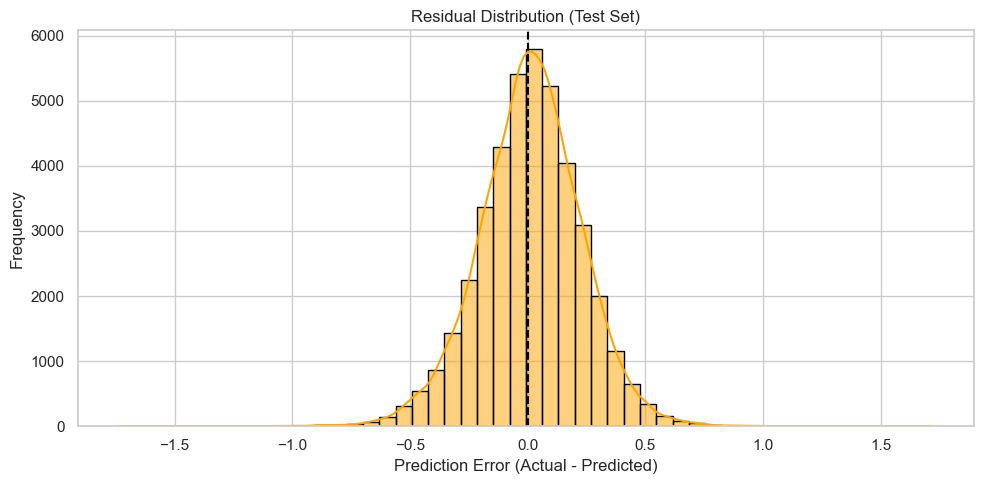

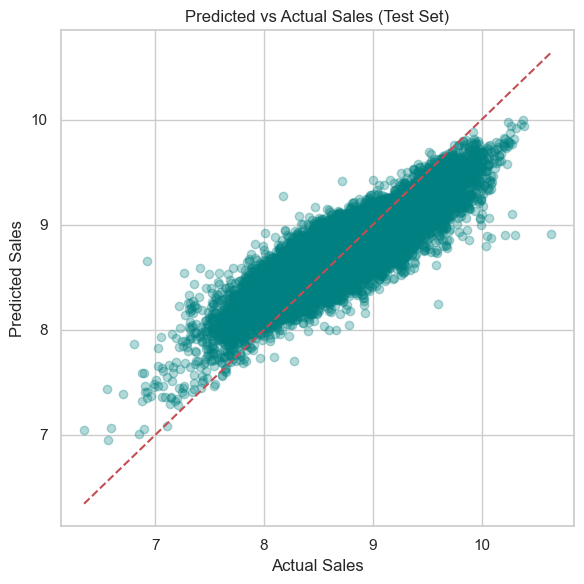

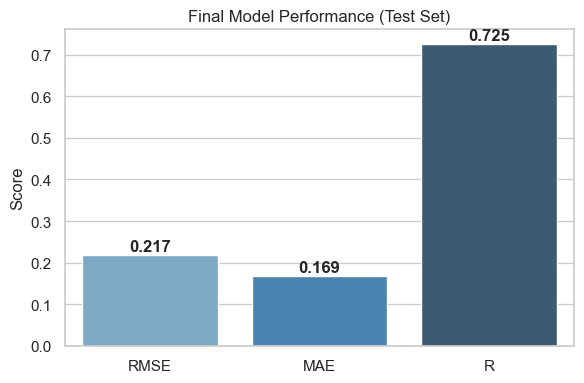

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Residuals
test_errors = y_test - final_preds

# --- Plot residual distribution (error between prediction and actual) ---
test_errors = y_test - final_preds

plt.figure(figsize=(10, 5))
sns.histplot(test_errors, bins=50, kde=True, color='orange', edgecolor='black')
plt.axvline(0, color='black', linestyle='--')
plt.title("Residual Distribution (Test Set)")
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Scatter plot to assess predicted vs. actual values ---
plt.figure(figsize=(6, 6))
plt.scatter(y_test, final_preds, alpha=0.3, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Ideal prediction line
plt.title("Predicted vs Actual Sales (Test Set)")
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot final metrics as bar chart for dashboard-style summary ---
import numpy as np
mse_raw = mean_squared_error(y_test, final_preds)
rmse = sqrt(mse_raw)
mae = mean_absolute_error(y_test, final_preds)
r2 = r2_score(y_test, final_preds)

metrics = ['RMSE', 'MAE', 'R']
values = [rmse, mae, r2]

plt.figure(figsize=(6, 4))
sns.barplot(x=metrics, y=values, palette='Blues_d')
plt.title("Final Model Performance (Test Set)")
plt.ylabel("Score")
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center', fontweight='bold')
plt.tight_layout()
plt.show()



## Section 8: Feature importance

Understand what the model has learned and how it makes predictions. 

This section covers global and local explanations using feature importance and SHAP analysis.

### Global feature importance (XGBoost gain-based)

- The chart below presents the top 20 most important features based on XGBoost’s gain metric, which reflects the relative improvement in model accuracy brought by each feature when used in decision splits.

- Promotion-related variables dominate:

  - The most influential predictors are promo_assortment_0_a and Promo, which highlights how promotions substantially drive sales. These variables consistently improve split quality during training, indicating strong predictive signal.

- Interaction terms matter:

  - Several top features are interaction terms, such as promo_assortment_0_c and promo_storetype_0_d, showing that the combination of promotional activity with store or assortment type adds significant modeling value. 
  
  - These engineered interactions allow the model to capture context-specific promotional effects.

- Store and assortment characteristics are also predictive:

  - Features like StoreType_b, promo_storetype_0_a, and store_assortment_b_c reflect how structural store attributes influence sales patterns—especially when interacting with marketing strategies.

- Lesser importance of temporal and distance features:
  
  - Variables like DayOfWeek, Promo2SinceYear, and CompetitionDistance appear near the bottom of the top 20. These contribute less to gain, suggesting their effects are either weaker or captured indirectly through other features.

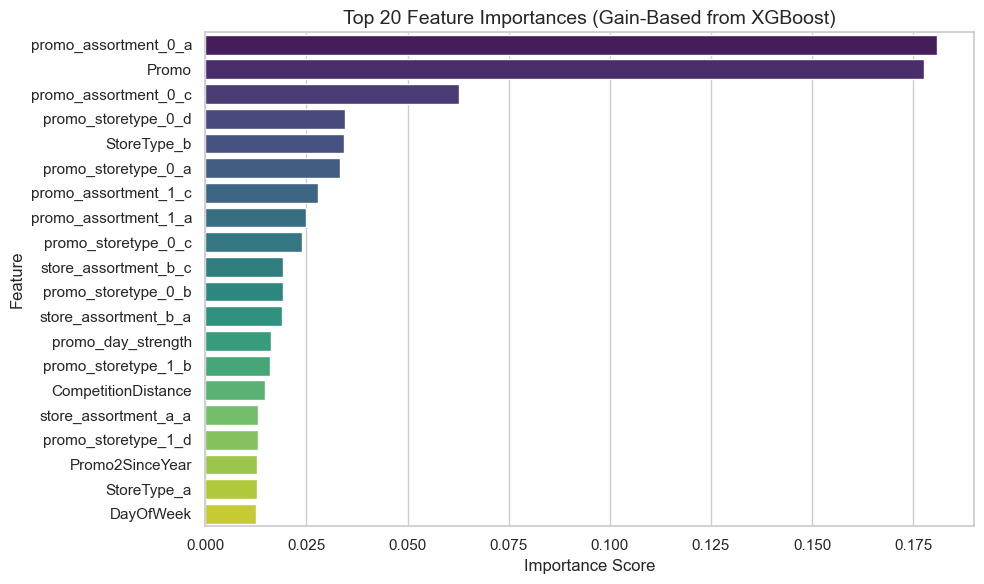

In [28]:
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a DataFrame of feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_trainval.columns,
    'Importance': final_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot the top 20 most important features
plt.figure(figsize=(10, 6))
sns.barplot(
    data=feature_importance_df.head(20),
    y='Feature',
    x='Importance',
    palette='viridis'
)
plt.title('Top 20 Feature Importances (Gain-Based from XGBoost)', fontsize=14)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Display top 20 as a formatted table
feature_importance_df.head(20).style.background_gradient(cmap="YlGnBu", subset=["Importance"])

# Save to CSV for documentation or business handoff
feature_importance_df.to_csv("../feature_importance_gain.csv", index=False)

### Permutation importance (model-agnostic, test set)

- The chart below shows the top 20 most influential features using permutation importance, which measures the decrease in model performance (R^2) when each feature's values are randomly shuffled. 

  - This technique helps validate how much the model truly depends on each variable during inference.

- CompetitionDistance is Most Critical:

  - Shuffling CompetitionDistance leads to the largest drop in R^2, indicating that proximity to competing stores significantly affects predicted sales. Its importance is even more pronounced here than in the gain-based XGBoost analysis.

- Store Identifier and Opening Dates Matter:
  
  - The Store ID and CompetitionOpenSinceMonth are highly ranked, suggesting store-specific effects and the age of local competition play a strong role in sales outcomes. These may be capturing fixed or latent store-level characteristics.

- Promotion Effects Still Appear:

  - Promotional variables like promo_assortment_0_a, Promo, and Promo2SinceYear remain important, but are slightly less dominant than in the XGBoost-specific gain ranking. 
  
  - This discrepancy suggests these features may contribute more to decision splits (gain) than to global performance stability (permutation).

- Temporal Variables Have Modest Impact:

  - Variables such as DayOfWeek, Day, and Promo2DurationWeeks show smaller but still non-trivial contributions. 
  
  - These may capture periodic trends or seasonality effects that support the model’s accuracy without being primary drivers.

- Less Impact from Some Engineered Features:
  
  - Features like promo_assortment_0_c and promo_day_strength, which were influential in the gain-based ranking, appear less critical here—indicating their contributions may be more structural (useful for split logic) than functional (useful for raw predictive power).

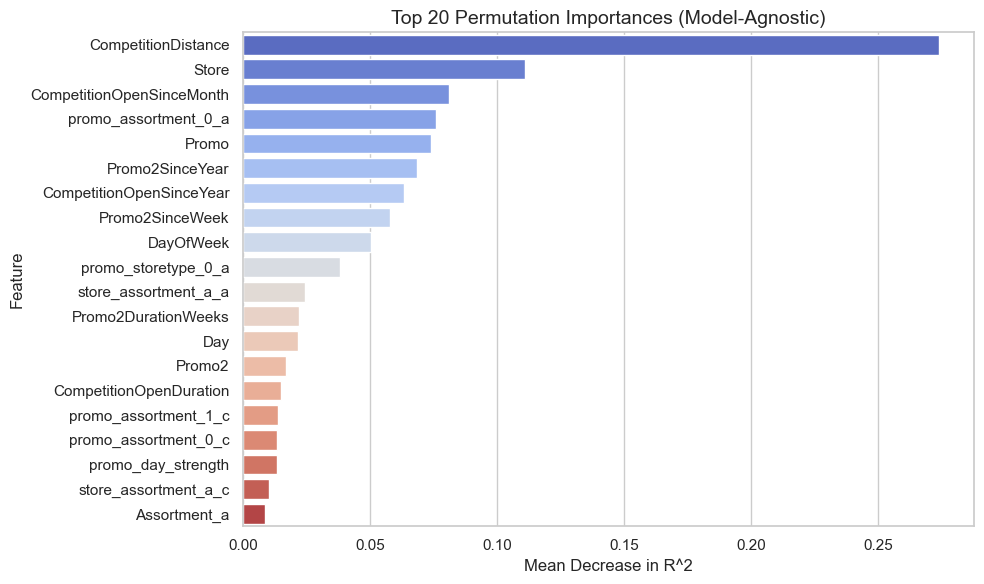

In [29]:
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Compute permutation importance on the test set
perm_results = permutation_importance(
    estimator=final_model,
    X=X_test,
    y=y_test,
    scoring='r2',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Store results in a DataFrame
perm_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': perm_results.importances_mean,
    'Std': perm_results.importances_std
}).sort_values(by='Importance', ascending=False)

# Plot top 20 permutation importance
plt.figure(figsize=(10, 6))
sns.barplot(
    data=perm_df.head(20),
    x='Importance',
    y='Feature',
    palette='coolwarm',
)
plt.title('Top 20 Permutation Importances (Model-Agnostic)', fontsize=14)
plt.xlabel('Mean Decrease in R^2')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


### Comparison of feature importances: gain-based vs. permutation (top 20 by permutation)

- This table compares two complementary approaches to feature importance:

  - Gain-Based Importance (from XGBoost): Reflects how often and how usefully a feature is used in decision splits within trees.

  - Permutation Importance: Reflects the actual decrease in model performance (R^2) when the feature is randomly shuffled, offering a model-agnostic perspective.

  - Promo and promo_assortment_0_a are dominant in both views:
  
    - These two features consistently rank at the top across both importance metrics, suggesting strong influence on model structure and prediction quality.

  - CompetitionDistance stands out in permutation but not gain:
  
  	- Despite having the highest permutation importance (0.274), CompetitionDistance ranks low in gain (0.016). 
  
  	- This indicates that while it might not be heavily split on, it carries substantial raw predictive signal—possibly due to its continuous nature, which may reduce its gain score in XGBoost.

  - Categorical promo/store type combinations show inflated gain:
  
    - Several one-hot encoded features like promo_storetype_1_b and store_assortment_b_a rank high on gain but near-zero on permutation. 
  
    - These likely help refine splits without having strong global predictive power, a common artifact of tree-based models handling sparse binary features.

  - Discrepancies highlight different model sensitivities:
  
    - Features like Promo2SinceYear, DayOfWeek, and StoreType_a show higher permutation than gain, indicating they contribute to model generalization even if not frequently used in splits.

In [30]:
# Join gain-based and permutation importances
merged_importance = feature_importance_df.merge(
    perm_df,
    on='Feature',
    how='inner',
    suffixes=('_Gain', '_Perm')
)

# Display top 20 by permutation
merged_importance.head(20).style.bar(subset=['Importance_Gain', 'Importance_Perm'], color='#5fba7d')

,Feature,Importance_Gain,Importance_Perm,Std
0,promo_assortment_0_a,0.180959,0.075928,0.000985
1,Promo,0.177568,0.074146,0.001031
2,promo_assortment_0_c,0.062841,0.013568,0.000437
3,promo_storetype_0_d,0.034557,0.007788,0.000166
4,StoreType_b,0.034217,0.002470,0.000054
5,promo_storetype_0_a,0.033322,0.038349,0.000325
6,promo_assortment_1_c,0.027765,0.014008,0.000238
7,promo_assortment_1_a,0.024976,0.008301,0.000133
8,promo_storetype_0_c,0.023861,0.005042,0.000099
9,store_assortment_b_c,0.019325,0.000900,0.000046


In [31]:
# Save for comparison with gain-based method
perm_df.to_csv("../permutation_importance.csv", index=False)
merged_importance.to_csv("../importance_comparison.csv", index=False)

### SHAP summary: top feature contributions to predictions

- This SHAP (SHapley Additive exPlanations) bar chart quantifies the average absolute contribution of each feature to the model’s predictions. 

  - It reflects how much each feature, on average, pushes the predicted value away from the base value (mean prediction), regardless of direction.

  - Promo is the most influential feature:
  
    - With an average SHAP contribution of +0.07, the presence or absence of a promotion is the strongest driver of predicted sales increases. This aligns with business intuition and validates the model's behavior.

  - CompetitionDistance and promo_assortment_0_a are also impactful:
  
    - Both features have substantial influence (~+0.05). This suggests proximity to competitors and specific promotion-assortment interactions play a meaningful role in shaping sales outcomes.

  - Calendar features show consistent but moderate impact:
  
    - Day, DayOfWeek, Promo2SinceYear, and Promo2SinceWeek each contribute ~+0.02 to +0.03, indicating the model successfully leverages temporal patterns without over-relying on them.

  - Store-specific and categorical interactions appear less influential individually:
  
  	- Features like store_assortment_a_a, promo_storetype_0_d, and Promo2 register minor SHAP values (~+0.01), suggesting their effects are subtle but possibly meaningful when combined.

  - Long tail of features has low individual impact:
  
  	- The bottom row shows that 33 other features collectively contribute ~+0.08, but individually, none are as impactful as the top drivers. This supports good feature compression and model generalization.

In [32]:
import shap
import pandas as pd
import matplotlib.pyplot as plt

# Initialize the SHAP explainer with the trained model
explainer = shap.Explainer(final_model)

# Compute SHAP values on a sample of the test set (for performance)
X_sample = X_test.sample(n=1000, random_state=42)
shap_values = explainer(X_sample)


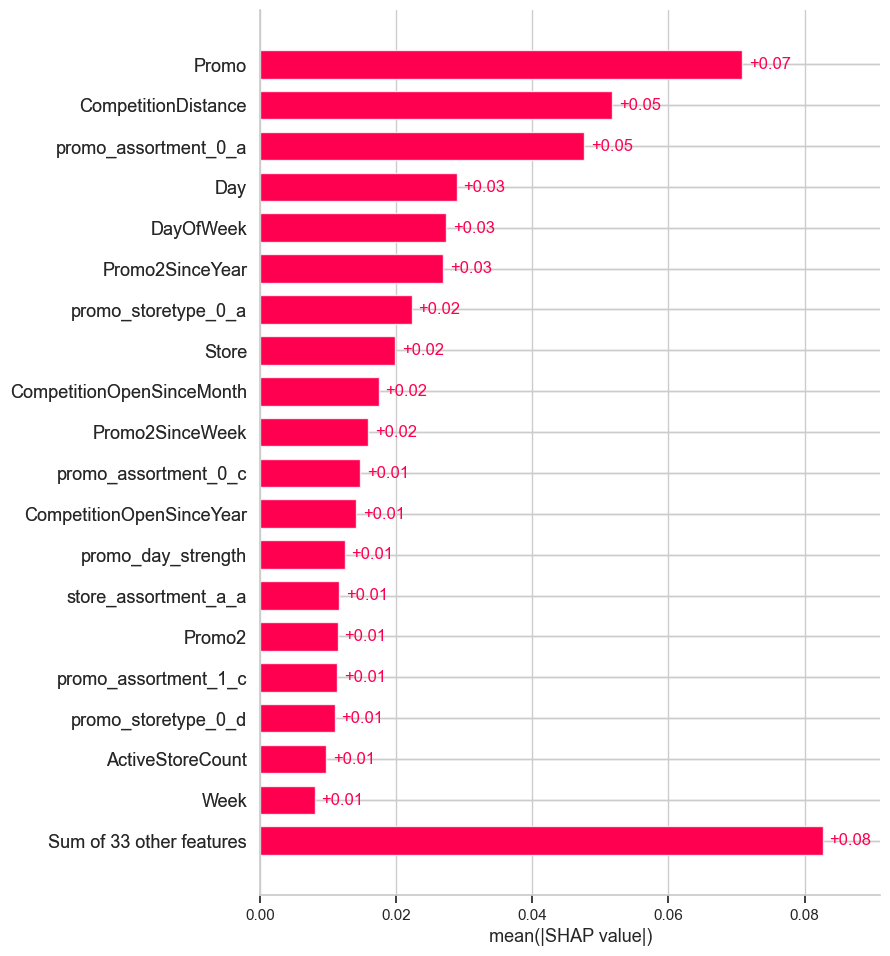

In [33]:
# Summary plot (bar chart of mean absolute SHAP values)
shap.plots.bar(shap_values, max_display=20)

### SHAP beeswarm plot: distribution and direction of feature impacts

- This SHAP beeswarm plot provides a detailed view of how each feature influences individual predictions across the test set. Each point represents a row in the dataset, with:

  - X-axis: SHAP value (magnitude and direction of impact on prediction)

  - Color: Feature value (from low [blue] to high [red])

  - Promo has the most consistent positive influence:
  
    - High Promo values (in red) drive predictions up, while low values (in blue) drag them down. This confirms that running a promotion reliably increases predicted sales.

  - CompetitionDistance impact is mixed and value-sensitive:
  
    - Low values (close competition, shown in red) tend to increase predicted sales, while higher values (blue) contribute negatively or neutrally. This suggests that stores with nearby competitors see stronger sales — likely due to favorable positioning or dense retail zones.

  - Promo-assortment interaction (promo_assortment_0_a) shows directional variance:
  
    - Its effect is non-uniform, with both high and low values contributing in different directions. 
  
    - This indicates its importance is context-dependent, likely tied to specific promotion strategies under Assortment A.

  - Day and DayOfWeek show periodic influence:
  
    - Their SHAP values form clustered bands, reflecting cyclical patterns in sales. 
  
    - Certain days of the week and month consistently boost or suppress predictions.

  - Store-related features (e.g., Store, store_assortment_a_a) generally contribute modestly:
  
    - These features have narrow SHAP distributions around zero, meaning their impact is relatively small or consistent.

    - Promo2-related features (e.g., Promo2SinceYear, Promo2SinceWeek) show mild positive contributions when present:
  
    - Their SHAP values skew slightly right, suggesting that longer-running or recent secondary promotions tend to help sales.

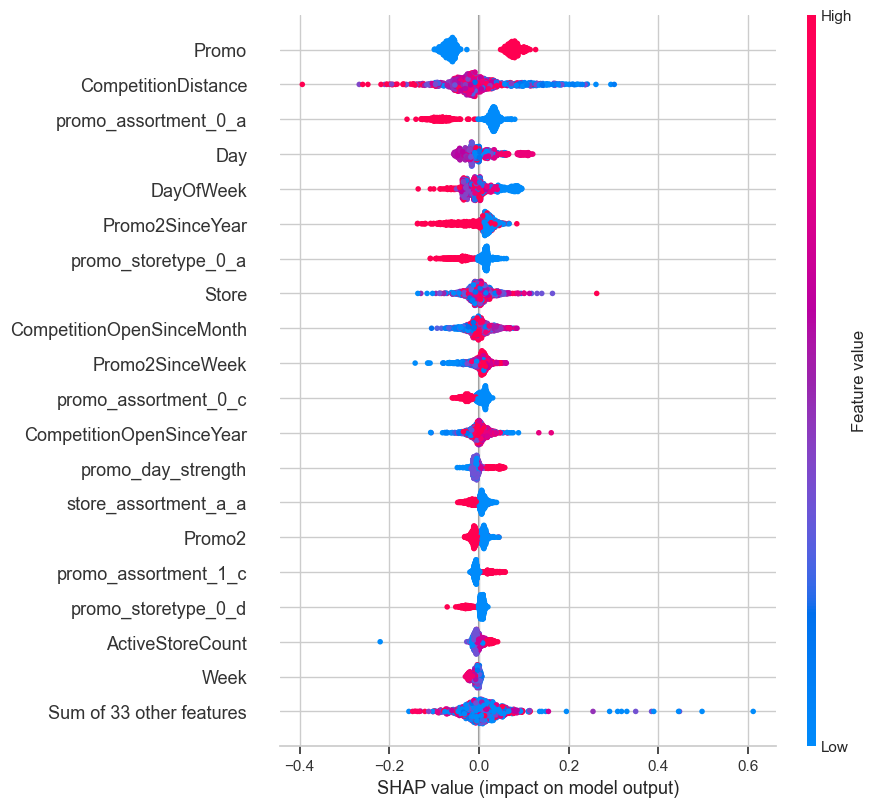

In [34]:
# Summary plot (beeswarm for interaction and direction)
shap.plots.beeswarm(shap_values, max_display=20)

### SHAP Mean Absolute Value Table: Average Feature Contributions

- This table ranks features by their mean absolute SHAP values, providing a clear, quantitative view of each variable's overall impact on the model's predictions—regardless of direction.

- Promo is the most impactful feature on average:

  - With a mean absolute SHAP value of approximately 0.071, the presence or absence of a promotion consistently influences the predicted sales across most data points.

- CompetitionDistance ranks second:

  - Although it doesn’t appear as the most important in gain-based importance, its high SHAP value here confirms it has consistent influence across many rows. 

  - Shorter distances (closer competitors) tend to increase predicted sales, aligning with prior SHAP and permutation plots.

- promo_assortment_0_a shows stable importance:

  - This interaction feature appears in the top 3, reinforcing its strong and consistent influence across various model interpretations.

- Calendar features like Day and DayOfWeek remain moderately influential:

  - Their presence near the top confirms regular patterns in daily or weekly sales fluctuations are important to model predictions.

- Store ID appears with non-trivial contribution:

  - Though not inherently interpretable, the Store feature might capture consistent store-level trends not otherwise represented, such as manager behavior or local market idiosyncrasies.

- Long-term promotion timing (Promo2SinceYear, Promo2SinceWeek) and
competition timing (CompetitionOpenSinceMonth/Year) exhibit smaller but consistent effects.

- Lower-ranked features still contribute marginally:

  - Variables like Promo2, Week, and Promo2DurationWeeks register low SHAP values, indicating limited but not negligible influence.

In [35]:
# Get mean absolute SHAP values per feature
shap_importance_df = pd.DataFrame({
    'Feature': X_sample.columns,
    'MeanAbsSHAP': np.abs(shap_values.values).mean(axis=0)
}).sort_values(by='MeanAbsSHAP', ascending=False)

# Show top 20 in a styled table
shap_importance_df.head(20).style.background_gradient(cmap="YlOrRd", subset=["MeanAbsSHAP"])

,Feature,MeanAbsSHAP
2,Promo,0.070852
4,CompetitionDistance,0.051772
30,promo_assortment_0_a,0.047610
12,Day,0.028854
1,DayOfWeek,0.027329
9,Promo2SinceYear,0.026915
22,promo_storetype_0_a,0.022272
0,Store,0.019849
5,CompetitionOpenSinceMonth,0.017402
8,Promo2SinceWeek,0.015849


In [37]:
# Save to CSV
shap_importance_df.to_csv("shap_global_summary.csv", index=False)

### SHAP Force Plots: Explaining Individual Predictions

- SHAP force plots provide a visual breakdown of how each feature contributes to an individual prediction, moving the model output away from the base value (the average prediction across the training data). 
  
  - Features pushing the prediction higher are shown in red, while those pushing it lower are in blue.

In [53]:
# Compute prediction errors
errors = np.abs(final_model.predict(X_sample) - y_test.loc[X_sample.index])

# Sort sample by error
error_sorted_indices = errors.sort_values(ascending=False).index

# Select 2 high-error and 1 low-error examples
i_high_1 = error_sorted_indices[0]
i_high_2 = error_sorted_indices[1]
i_low = error_sorted_indices[-1]

# You can replace with domain-specific examples, e.g., X_sample[X_sample["Store"] == 321]


1. High-Error Prediction (Predicted = 8.64)

   - This prediction is significantly overestimated, with the actual value notably lower.

    - Positive contributors include:

        - Promo = 1 (major upward force),

        - promo_assortment_0_a = 0,

        - Day = 0,

        - Promo2SinceYear = -1 (likely treated as missing or a default placeholder).

    - Negative contributors (which were not enough to offset the upward force):

        - Store = 543,

        - CompetitionDistance = 6.988,

        - CompetitionOpenSinceMonth = 3.

    - Interpretation: The model overemphasized promotion-related effects while underweighting store- or competition-based moderating factors.

In [54]:
# Force plot for high-error prediction 1
shap.plots.force(shap_values[X_sample.index.get_loc(i_high_1)])


2. High-Error Prediction (Predicted = 8.28)

    - This prediction appears to be underestimated.

    - Strong negative contributions include:

        - Promo = 0,

        - promo_storetype_0_a = 1,

        - promo_assortment_0_c = 1.

    - Positive contributors:

        - promo_assortment_0_a = 0 (likely missing or suppressed),

        - Day = 25.

    - Interpretation: The model was likely penalized by promo absence and perceived store type/assortment, despite some signals (e.g., Day, Store) indicating a potentially higher value.

In [55]:
# Force plot for high-error prediction 2
shap.plots.force(shap_values[X_sample.index.get_loc(i_high_2)])


3. Low-Error Prediction (Predicted = 8.70)

    - This case was predicted with high accuracy.

    - Strong positive contributors:

        - Promo = 1,

        - promo_assortment_0_a = 0,

        - Day = 23.

    - Strong negative contributors:

        - Promo2SinceYear = 2.013,

        - CompetitionDistance = 7.353,

        - DayOfWeek = 3.

In [56]:
# Force plot for a low-error prediction
shap.plots.force(shap_values[X_sample.index.get_loc(i_low)])


### SHAP Insights Summary

- SHAP analysis revealed key business drivers of sales predictions:

  - Promotions had the strongest positive impact, confirming that promotional campaigns significantly boost sales.

  - Competition Distance was also influential; stores farther from competitors tend to perform better.

  - Assortment and Store Type interactions played a secondary but meaningful role, suggesting certain store-assortment combinations respond better to promotions.

  - Temporal factors like Day of Week and Promo2 start timing had moderate influence, hinting at seasonal and operational effects.

  - Many engineered features had minimal impact, validating the model’s focus on a core set of business-relevant variables.

- These insights can guide marketing focus, store placement strategy, and promotional timing decisions.

### Section 9: Final Summary, Export, and Next Steps

- This notebook presents a complete machine learning pipeline for forecasting daily retail sales using historical data from Rossmann stores. 

- The workflow prioritized temporal integrity, leakage prevention, and interpretability from start to finish.

- Project Highlights

  - Target: Log-transformed daily sales

  - Model: XGBoost Regressor tuned with Optuna

  - Validation: Time-aware split with leakage checks

    - Final Metrics (Test Set):

        - RMSE: 0.2173

        - MAE: 0.1687

        - R^2: 0.7247

- Feature Engineering

- Engineered features captured:

  - Promo timing and intensity

  - Competition duration and distance

  - Assortment and store-type interactions

  - Rolling store averages (calculated only from training data)

- These additions improved performance and provided domain-aligned context for interpretation.

- Interpretability

  - Gain Importance: Promo-related features dominated model gains

  - Permutation Importance: CompetitionDistance and Store ID ranked highest in model-agnostic tests

  - SHAP Values: Showed strong positive effects for active promotions and low competition proximity, with stable behavior across subgroups

- Residual Diagnostics

  - Residuals showed no major segment bias and followed a roughly normal distribution, indicating consistent model behavior.

- Key Takeaways

  - Accurate, leak-free forecasting with strong alignment between predictions and actuals

  - Interpretable insights into drivers of sales performance

  - Reproducible pipeline from raw data to final results

### Exporting Artifacts

- This step saves all essential components of the final modeling pipeline for future reuse, deployment, or analysis. Specifically, it exports:
  
  - The trained XGBoost model (`.joblib` format)
  
  - The processed test features and labels (`.csv` format)
  
  - A prediction file comparing actual vs. predicted values

- All artifacts are stored in the `exports/` directory to ensure the pipeline is reproducible and ready for deployment or reporting.

In [65]:
import joblib
import os

# Create export folder if it doesn't exist
os.makedirs("exports", exist_ok=True)

# Save the final trained model
joblib.dump(final_model, "exports/xgb_final_model.joblib")

# Save processed test set
X_test.to_csv("exports/X_test_processed.csv", index=False)
y_test.to_csv("exports/y_test_processed.csv", index=False)

# Save test predictions
pd.DataFrame({
    "Actual": y_test,
    "Predicted": final_preds
}).to_csv("exports/test_predictions.csv", index=False)

print("Artifacts exported to 'exports/' folder.")

Artifacts exported to 'exports/' folder.
